# Investigating Biodiversity Intactness Index change in Phoenix subdivision

Author: Anna Ramji ([Githhub](https://github.com/a-ramji)) ([website](https://a-ramji.github.io/))
- repository for this notebook: https://github.com/a-ramji/biodiv-index-phoenix

### Context & Purpose

In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). Urban sprawl creates pressure on biodiversity and natural areas. 


In this notebookk I will explore a dataset showing values for biodiversity intactness index (BII) [2](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf), [3](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) to find changes in this BII around the Phoenix area from 2017 to 2020. 


### Highlight of Analysis

-  In this notebook, I will start by accessing the `io-biodiversity` collection from the MPC STAC catalog and retrieve the 2017 and 2020 rasters covering Phoenix subdivision.

- I will read in a shapefile containing the Phoenix subdivision polygon from the [Census County Subdivision shapefiles for Arizona](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)

- After some brief data exploration and preliminary plotting, I will make a map of the Phoenix Subdivision, showing geographical context.

- I will then create and display a plot of the BII data within the Phoenix subdivision polygon

- I will calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020

- Finally, I will plot the 2020 BII data in the Phoenix subdivision, emphasizing areas where there was a loss of areas with a BII of at least 0.75 in 2017 by 2020. 


### Data descriptions & References

1. BII data: This dataset is part of the MPC STAC catalog. In this notebook, I'm using the `io-biodiversity` collection, specifically the rasters covering the Phoenix subdivision in 2017 and 2020. This dataset was generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/). It contains terrestrial biodiversity intactness data at 100m resolution. 

Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness (*'io-biodiversity'*). [Dataset].  https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 6 December 2023.


2. United States Census Bureau, County Subdivision shapefiles for Arizona. County subdivision level census data from 2022. This data is used to mask/crop our raster data, and to add an outline to our final plot. 


United States Census Bureau. (2022). *Arizona County Subdivision 2022 TIGER/Line Shapefiles*. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Accessed 6 December 2023.

Let's start by importing our necessary libraries and packages:

In [1]:
# importing libraries with standard abbreviations

import os # for reproducible file paths
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # for custom legend


# geospatial tools
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

# planetary computer tools
import pystac_client
import planetary_computer

# for images and mapping
from IPython.display import Image
import contextily as ctx #for adding basemaps

Now we can move on to reading in our BII collection from the MPC STAC catalog, using a bounding box to help define our search area.

## Reading in the Data

### MPC STAC catalog's `io-biodiversity` BII Data

In [2]:
# open MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around Phoenix subdivision
bbox = [-112.826843,
        32.974108,
        -111.184387,
        33.863574]

# specifying our time range
time_range = "2017/2020"

# search through the io-biodiversity collection
search = catalog.search(
    collections=["io-biodiversity"],
    bbox = bbox,
    datetime = time_range)

# get items from the search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

# retrieve items
item_names = {item.id : item for item in search.items()}
list(item_names) # from this list, we can see that our 1st item is 2020 data, and our 4th item is 2017 data

# select 2017 subset
px_2017 = items[3]

# select 2020 subset
px_2020 = items[0]

There are 4 items in the search.


### Arizona Census County Subdivision data

In [3]:
# reading in arizona census county subdivision-level shapefile

# display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

arizona_fp = os.path.join("data", "tl_2022_04_cousub.shp")
arizona = gpd.read_file(arizona_fp)

# preliminary (brief) exploration
arizona.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


Let's clean up the column names and then select Phoenix County.

In [4]:
arizona.columns = arizona.columns.str.lower()

phoenix = arizona[arizona.name == "Phoenix"]

# phoenix.plot()

When working with geospatial data, it's important to know what CRS your data is in, as we need our datasets to share the same CRS in order to perform any meaningful analysis.

In [5]:
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

- note: the CRS is EPSG:4269

## Geographical context: Map of Phoenix county

Let's show the area we'll be looking at in the rest of our analysis with geographical context. To do this, we'll add a basemap from the [Contextily](https://contextily.readthedocs.io/en/latest/) package, specifying that we want to use Esri's NatGeo World Map. By default, `contextily` uses the [OpenStreetMap HOT](http://map.hotosm.org/) style. We can change basemaps by updating the `source` parameter in the `add_basemap()` function.

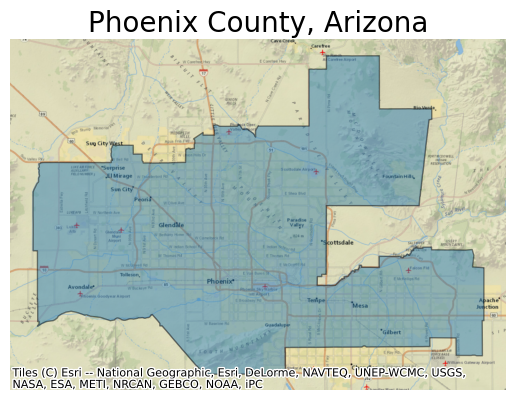

In [6]:
# set up figure
fig, ax = plt.subplots()

# create axis with plot
(phoenix.to_crs(epsg=3857) 
      .plot(ax=ax, figsize=(11, 10), alpha=0.45, edgecolor="k"))

# add NatGeo basemap from contextily
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County, Arizona", fontdict= {"fontsize": "20"})
ax.set_axis_off()

# saving map as an image so we can input it elsewhere in our notebook
plt.savefig('figures/phoenix_county.png', bbox_inches = "tight", dpi = 100)

Nice to see where we're looking at with more geographical context! 

Let's move on to plotting our BII data within that Phoenix subdivision polygon. We'll first need to find which `asset` has our Biodiversity Intactness data, and then need tp 

### Plotting Biodiversity Intactness in the Phoenix subdivision 

In [7]:
for key in px_2017.assets.keys():
    print(key, '--', px_2017.assets[key].title) 
# print key, separator, print / access the item assets of that key, get the title

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Notice the "data" asset, which contains the biodiversity intactness data that we want. Each asset also contains an href, which we can use to directly access and open the data that we want to work with in our analysis. 

Let’s access this data asset with BII for both 2017 and 2020:

In [8]:
# retrieving 2017 biodiversity data and href to plot
px_2017_asset = px_2017.assets["data"]

px_2017_data = rioxr.open_rasterio(px_2017_asset.href)

# uncomment to see the data within our larger bounding box
# px_2017_data.plot()

# defining 2020 data asset
px_2020_asset = px_2020.assets["data"]

px_2020_data = rioxr.open_rasterio(px_2020_asset.href)

Now that we have our data, we'll need to crop it to the Phoenix subdivision polygon. To do this, we first need to have the CRSs match, and then use the geometries of the polygon to crop our BII raster data to. 

In [9]:
px_2017_data.rio.crs

CRS.from_epsg(4326)

Note: this is different from our Phoenix shapefile CRS. Let's reproject our Phoenix shapefile to match the crs epsg 4326

In [10]:
phoenix = phoenix.to_crs(px_2017_data.rio.crs)

# uncomment to check to see if the crs was properly updated
print(phoenix.crs == px_2017_data.rio.crs)

True


Now we can move on to clip our 2017 and 2020 Phoenix data to the geometry of the Phoenix subdivision polygon.

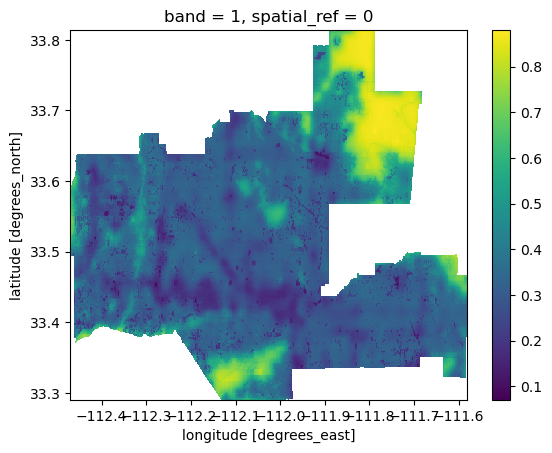

In [11]:
# clipping 2017 BII raster to the Phoenix polygon
phoenix_clipped_2017 = px_2017_data.rio.clip(phoenix["geometry"])

# performing this same step for the 2020 data:
phoenix_clipped_2020 =  px_2020_data.rio.clip(phoenix["geometry"])

# viewing the output of this step (our BII cropped to Phoenix subdivision)
phoenix_clipped_2017.plot()

In [12]:
phoenix_clipped_2017.count().item()

338694

Now that we have our data cropped to our area of interest, we can continue with our analysis.

### Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020

In this section we'll perform the following tasks:
1. Find the areas (number of pixels) with a Biodiversity Intactness Index value of at least 0.75 in 2017 and in 2020
2. Get the total area (number of pixels) in our Phoenix subdivision polygon for both 2017 and 2020
3. Calculate the percentage of area in each year that had a BII of at least 0.75

**Let's start by finding the number of pixels in each year that meet a condition: BII ≥ 0.75**

In [13]:
# finding values where the BII was greater than or equal to 0.75 in 2017, classifying those cells as 1,
# everything at or below 0.75 classified as 0

phoenix_bii_2017 = (phoenix_clipped_2017 >= 0.75).astype(int)
# phoenix_bii_2017

# doing the same for 2020 data
phoenix_bii_2020 = (phoenix_clipped_2020 >= 0.75).astype(int)
# phoenix_bii_2020

#### Caclulating percentage area 

Now, to find percentage area, for each year of data, we'll start by finding the total area of our Phoenix subdivision and divide our pixels in the ≥ 0.75 class by that total area, then multiply by 100 to get the percentage:

$ \frac{(pixels in class)}{(total pixels)} * 100 $,

where our "pixels in class" refer to the pixels with values of "1" in the objects we just defined above.


In [14]:
# finding total area for 2017 data:
# using .count() to count the number of pixels in the *polygon*, not the raster 
total_area_2017 = phoenix_clipped_2017.count().item() # using .item() to access just the value

# and total area for 2020 data:
total_area_2020 = phoenix_clipped_2020.count().item()

# finding the total area in the bii > 0.75 class for 2017 data:
# using .sum() here to total up the number of pixels in the polygon that meet our condition
pixels_in_class_2017 = phoenix_bii_2017.sum().item() # using .item() to access just the value

# and for 2020:
pixels_in_class_2020 = phoenix_bii_2020.sum().item()


# calculating the percentage area for 2017 data:
pct_bii_2017 =  (pixels_in_class_2017 / total_area_2017) * 100

# and percentage area for 2020 data:
pct_bii_2020 = (pixels_in_class_2020 / total_area_2020) * 100

# viewing percentages:

pct_text = "The percentage of area in Phoenix County with a BII over 0.75 in"
print(pct_text, "2017 is: ", round(pct_bii_2017, 2), "%")

print(pct_text, "2020 is: ", round(pct_bii_2020, 2), "%")

The percentage of area in Phoenix County with a BII over 0.75 in 2017 is:  7.13 %
The percentage of area in Phoenix County with a BII over 0.75 in 2020 is:  6.49 %


## Visualizing BII loss in the Phoenix subdivision from 2017 to 2020

Now that we've found and classified the areas where the BII ≥ 0.7 in 2017 and 2020, we can visualize these changes over time. Our end goal here is to make a map of our 2020 BII data and Phoenix polygon, highlighting areas (pixels) where there was a loss in BII from 2017 to 2020. 

We'll start by finding the difference in BII between the two years (subtracting 2017 pixels where BII ≥ 0.75 by 2020 pixels where BII ≥ 0.75), and use that data as a layer in our final plot to emphasize the areas with BII loss in 2020. 

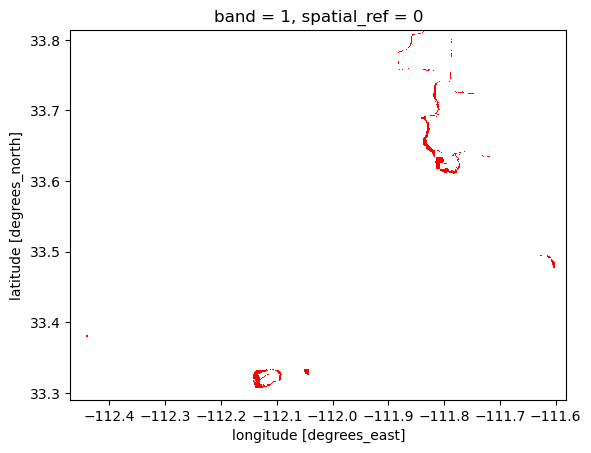

In [15]:
# first, we'll find areas where there was a loss in BII from 2017 to 2020
phx_bii_diff = phoenix_bii_2017 - phoenix_bii_2020

# to make our mask, we'll need to select pixels where the difference == 1
# basically, pixels that were BII >= 0.75 in 2017, but NOT in 2020, 
# will be selected because those are areas where there was BII loss
phx_bii_loss = phx_bii_diff == 1

# converting from boolean to integer for easier plotting and manipulation later
phx_bii_loss = phx_bii_loss.astype(int)

# uncomment to check plotting 
# phx_bii_loss.plot()

# let's customize this mask and recolor our BII loss areas for emphasis:
color_id = ["none", # set non-1 values to be transparent so it doesn't obscure our map later on 
            "red"] # color loss areas red

# creating a colormap object, feeding it our list of colors
cmap = plt.cm.colors.ListedColormap(color_id)

# check to see if our mask was successfully customized:
phx_bii_loss.plot(cmap = cmap, add_colorbar = False)

Great! Now we can make our final visualization.

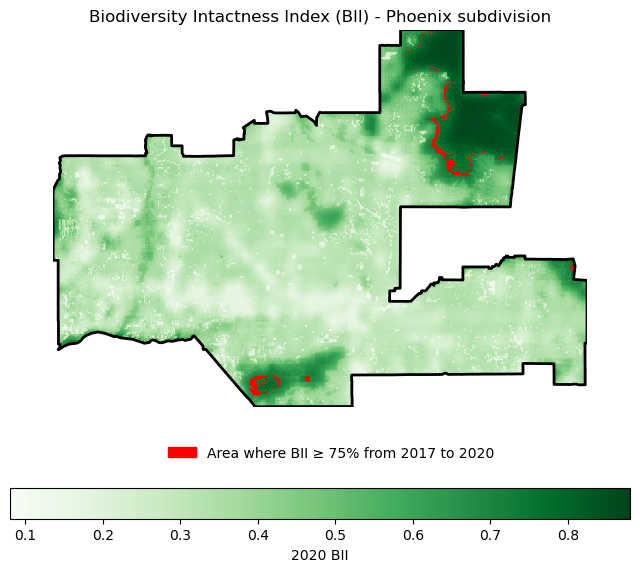

<Figure size 640x480 with 0 Axes>

In [16]:
# BII loss visualization

# ======= Initialize plot ======== #
fig, ax = plt.subplots(figsize = (8, 7))

# remove axes for a cleaner plot
ax.axis("off")


# ======= Phoenix 2020 BII Raster layer ========== #
phoenix_clipped_2020.plot(ax = ax,  # share axes 
                          cmap = "Greens", 
                          cbar_kwargs = {"location": "bottom", # for intuitive biodiversity sense
                                       "label": "2020 BII"}) 


# ======= BII Loss layer ======== #

phx_bii_loss.plot(ax = ax, # share axes
                  cmap = cmap, # our predefined colormap object
                  add_colorbar = False # we're going to make a custom legend, so we don't want the default one
                  )

phx_bii_loss_patch = mpatches.Patch(color = "red",
                                   label = "Area where BII ≥ 75% from 2017 to 2020")


# ======= Phoenix polygon outline layer ====== #
phoenix.plot(ax = ax, # share axes (on the same plot as everything else)
             color = "none", # transparent fill, we just want the outline
             edgecolor = "black",
             linewidth = 2
            )


# ======= Customizing our map ======== #

# update legend, add in BII loss patch
ax.legend(handles = [phx_bii_loss_patch],
          frameon = False,
          bbox_to_anchor = (0.85, -0.07))

# update title
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix subdivision")

# view plot
plt.show()

# Save figure as image to figures folder
plt.savefig("figures/bii_phoenix_final.png", bbox_inches = "tight", dpi = 100)